# PyTorch paper replication for Vision transformer

Turn the research paper into usable code.

### Get setup

Import already written code and libraries.

In [1]:
import os
print(os.getcwd())

D:\python_projects\Gym\pytorch


In [2]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.7.1+cu126
Torchvision version: 0.22.1+cpu


In [4]:
import torchinfo


from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

D:\python_projects\Gym\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Get data

Replicate the ViT architecture for FoodVisionMini.

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Create datasets and dataloaders

In [11]:
from going_modular import data_setup
from torchvision import transforms

# Create image size
IMAGE_SIZE = 224  # ViT paper uses 224x224 images

#Create data transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [13]:
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x254380c38b0>,
 ['pizza', 'steak', 'sushi'])

In [14]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### Visualize a single image and its label



In [15]:
# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label
image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

Text(0.5, 1.0, 'sushi')

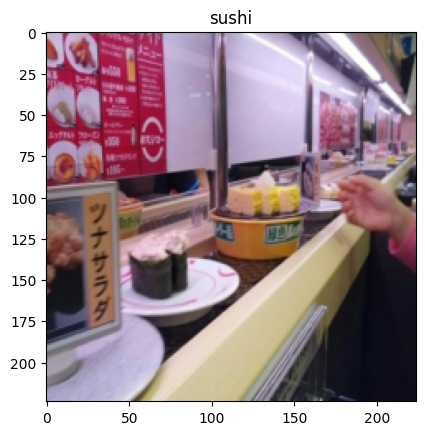

In [16]:
# PLot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])